In [ ]:
# Note size is 497x497x1 with alpha values, so need to change that

In [1]:
# Download the validation data, merge this on getting the test set
! gdown https://drive.google.com/u/2/uc?id=1WzVpmOZg1J2ze_dZ2mBLd5FQ6O1OzkAh

Downloading...
From: https://drive.google.com/u/2/uc?id=1WzVpmOZg1J2ze_dZ2mBLd5FQ6O1OzkAh
To: /content/validation_data_qubiq2021.zip
582MB [00:12, 48.4MB/s]


In [2]:
! unzip -qq validation_data_qubiq2021.zip

In [3]:
# Download the training data here
! gdown https://drive.google.com/u/2/uc?id=191aQKYXXmw2lgfc_WJcm1IL4Pt3fmEhC

Downloading...
From: https://drive.google.com/u/2/uc?id=191aQKYXXmw2lgfc_WJcm1IL4Pt3fmEhC
To: /content/training_data_v3.zip
1.52GB [00:30, 49.7MB/s]


In [4]:
! unzip -qq training_data_v3.zip

In [11]:
! gdown https://drive.google.com/u/2/uc?id=1R2sPVfw4w2AxRviQwa3ZozkU7sH10tL4

Downloading...
From: https://drive.google.com/u/2/uc?id=1R2sPVfw4w2AxRviQwa3ZozkU7sH10tL4
To: /content/QUBIQ21_test.zip
682MB [00:04, 182MB/s]


In [12]:
! unzip -qq QUBIQ21_test.zip

In [5]:
# make the output folder here
! mkdir prostate

In [6]:
# make a copy of seg masks for this state
! cp /content/training_data_v3/prostate/Training/case09/task01_seg02.nii.gz /content/training_data_v3/prostate/Training/case09/task01_seg03.nii.gz 
! cp /content/training_data_v3/prostate/Training/case09/task02_seg02.nii.gz /content/training_data_v3/prostate/Training/case09/task02_seg03.nii.gz 

In [7]:
import cv2
import glob
import numpy as np
import nibabel as nib
import skimage.io as io
from nibabel import nifti1
from nibabel.viewers import OrthoSlicer3D
import matplotlib.pyplot as plt

import glob
import json
import os
import cv2
import glob
import numpy as np
from numpy import  *
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Nadam, Adam, SGD, RMSprop
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score, recall_score


In [8]:
# All the losses are present here

from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf 

epsilon = 1e-5
smooth = 1

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)
    return intersection/union


In [9]:

import os
import json
import cv2
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add, Subtract, multiply
from keras.models import Model, model_from_json
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K


from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
# from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
# from keras.optimizers import SGD
# from keras.optimizers import *
from keras.layers import *      

def AttentionBlock(filters, inp_1, inp_2):
    '''
    AttentionBlock
    Arguments:
        filters {int} -- [description]
        inp_1 {keras layer} -- input layer
        inp_2 {keras layer} -- input layer
    Returns:
        [keras layer] -- [output layer]
    '''

    # Take the original image as the attention multiplication factor, i.e., inp_1
    attention_mult = inp_1
    inp_1 = Conv2D(filters, (3, 3), activation= 'relu', strides=1, padding='same')(inp_1)
    inp_2 = Conv2D(filters, (3, 3), activation= 'relu', strides=1, padding='same')(inp_2)
    subtract_1 = Conv2D(filters, (3, 3), activation= 'tanh', strides=1, padding='same')(keras.layers.Subtract(name="subtract")([inp_1, inp_2]))
    multiply_1 = Conv2D(filters, (3, 3), activation= 'sigmoid', strides=1, padding='same')(multiply([attention_mult, subtract_1]))
    return multiply_1

def QUBIQ_NET(height, width, n_channels):
    N = height
    
    inputs = Input(shape=(height, width, 1), name="input_image")
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    in_conv1 = conv1
  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)     
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)     
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)
    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1) 
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)
            
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)    

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    



    

    conv_1_out = concatenate([conv8, in_conv1])
    conv_1_out = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_1_out)
    conv_1_out = Conv2D(1, 1, activation = 'sigmoid', name="out1")(conv_1_out)

    conv_2_out = concatenate([conv8, in_conv1])
    conv_2_out = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_2_out)
    conv_2_out = Conv2D(1, 1, activation = 'sigmoid', name="out2")(conv_2_out)

    conv_3_out = concatenate([conv8, in_conv1])
    conv_3_out = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_3_out)
    conv_3_out = Conv2D(1, 1, activation = 'sigmoid', name="out3")(conv_3_out)

    conv_4_out = concatenate([conv8, in_conv1])
    conv_4_out = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_4_out)
    conv_4_out = Conv2D(1, 1, activation = 'sigmoid', name="out4")(conv_4_out)

    conv_5_out = concatenate([conv8, in_conv1])
    conv_5_out = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_5_out)
    conv_5_out = Conv2D(1, 1, activation = 'sigmoid', name="out5")(conv_5_out)

    conv_6_out = concatenate([conv8, in_conv1])
    conv_6_out = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_6_out)
    conv_6_out = Conv2D(1, 1, activation = 'sigmoid', name="out6")(conv_6_out)

    conv_7_out = concatenate([conv8, in_conv1])
    conv_7_out = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_7_out)
    conv_7_out = Conv2D(1, 1, activation = 'sigmoid', name="out7")(conv_7_out)

    conv_8_out = concatenate([conv8, in_conv1])
    conv_8_out = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_8_out)
    conv_8_out = Conv2D(1, 1, activation = 'sigmoid', name="out8")(conv_8_out)

    conv_9_out = concatenate([conv8, in_conv1])
    conv_9_out = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_9_out)
    conv_9_out = Conv2D(1, 1, activation = 'sigmoid', name="out9")(conv_9_out)

    conv_10_out = concatenate([conv8, in_conv1])
    conv_10_out = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_10_out)
    conv_10_out = Conv2D(1, 1, activation = 'sigmoid', name="out10")(conv_9_out)

    conv_11_out = concatenate([conv8, in_conv1])
    conv_11_out = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_11_out)
    conv_11_out = Conv2D(1, 1, activation = 'sigmoid', name="out11")(conv_9_out)

    conv_12_out = concatenate([conv8, in_conv1])
    conv_12_out = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_12_out)
    conv_12_out = Conv2D(1, 1, activation = 'sigmoid', name="out12")(conv_9_out)

    model = Model(inputs = [inputs], outputs = [conv_1_out, conv_2_out, conv_3_out, conv_4_out, conv_5_out, 
                                                conv_6_out, conv_7_out, conv_8_out, conv_9_out, conv_10_out, 
                                                conv_11_out, conv_12_out])


    # model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model



In [10]:
model = QUBIQ_NET(height=256, width=256, n_channels=1)
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, jacard, 'accuracy'])
# model.compile(optimizer=Adam(learning_rate=1e-5),loss='binary_crossentropy',metrics=[dice_coef, jacard, Recall(), Precision(), 'accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_image[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
! mv /content/validation_data_qubiq2021/prostate/Validation/* /content/training_data_v3/prostate/Training/

In [14]:
! mv /content/QUBIQ21_test/prostate/Testing/* /content/validation_data_qubiq2021/prostate/Validation/

In [15]:
ALL_FILES = glob.glob('/content/training_data_v3/prostate/Training/*')
print(ALL_FILES)

['/content/training_data_v3/prostate/Training/case20', '/content/training_data_v3/prostate/Training/case40', '/content/training_data_v3/prostate/Training/case10', '/content/training_data_v3/prostate/Training/case53', '/content/training_data_v3/prostate/Training/case07', '/content/training_data_v3/prostate/Training/case23', '/content/training_data_v3/prostate/Training/case33', '/content/training_data_v3/prostate/Training/case16', '/content/training_data_v3/prostate/Training/case37', '/content/training_data_v3/prostate/Training/case26', '/content/training_data_v3/prostate/Training/case03', '/content/training_data_v3/prostate/Training/case48', '/content/training_data_v3/prostate/Training/case44', '/content/training_data_v3/prostate/Training/case09', '/content/training_data_v3/prostate/Training/case45', '/content/training_data_v3/prostate/Training/case47', '/content/training_data_v3/prostate/Training/case42', '/content/training_data_v3/prostate/Training/case32', '/content/training_data_v3/

In [16]:
NO_OF_FILES = glob.glob(ALL_FILES[0]+'/*')
print(NO_OF_FILES)
print("No. of files = ",len(NO_OF_FILES))

# this will be the no. of masks for each of the datasets, 
# since the datasets have one image file and other as mask files

NO_OF_MASKS = len(NO_OF_FILES) - 1 
print(NO_OF_MASKS)

['/content/training_data_v3/prostate/Training/case20/task01_seg02.nii.gz', '/content/training_data_v3/prostate/Training/case20/task02_seg03.nii.gz', '/content/training_data_v3/prostate/Training/case20/task02_seg01.nii.gz', '/content/training_data_v3/prostate/Training/case20/task01_seg03.nii.gz', '/content/training_data_v3/prostate/Training/case20/task01_seg05.nii.gz', '/content/training_data_v3/prostate/Training/case20/task01_seg06.nii.gz', '/content/training_data_v3/prostate/Training/case20/task02_seg06.nii.gz', '/content/training_data_v3/prostate/Training/case20/image.nii.gz', '/content/training_data_v3/prostate/Training/case20/task01_seg01.nii.gz', '/content/training_data_v3/prostate/Training/case20/task02_seg05.nii.gz', '/content/training_data_v3/prostate/Training/case20/task01_seg04.nii.gz', '/content/training_data_v3/prostate/Training/case20/task02_seg04.nii.gz', '/content/training_data_v3/prostate/Training/case20/task02_seg02.nii.gz']
No. of files =  13
12


In [17]:
# Rescale here itself between 0 and 1

X_train = []
Y_train = [[] for i in range(NO_OF_MASKS)]
AFFINE = 0

for folders in ALL_FILES:
    each_img_file = glob.glob(folders+"/image.nii.gz")[0]
    epi_img = nib.load(each_img_file)
    epi_img_data = epi_img.get_fdata()
    # print(epi_img_data.shape)
    epi_img_data = cv2.resize(epi_img_data,(256, 256), interpolation = cv2.INTER_AREA)
    epi_img_data = epi_img_data/epi_img_data.max()
    # single channel grayscale inputs 
    
    X_train.append(epi_img_data)

    mask_files_all = sorted(glob.glob(folders+"/*seg*"))
    # print(folders," = ",len(mask_files_all))
    iter_i = 0
    for files in mask_files_all:
        
        epi_mask = nib.load(files)
        AFFINE = epi_mask.affine
        epi_mask_data = epi_mask.get_fdata()
        # print(files," ",epi_mask_data.shape)
        epi_mask_data = cv2.resize(epi_mask_data,(256, 256), interpolation = cv2.INTER_AREA)
        # plt.imshow(epi_mask_data, cmap='gray')
        # plt.show()
        Y_train[iter_i].append(epi_mask_data)
        # print(iter_i)
        iter_i += 1

len(Y_train)

12

In [18]:
print("AFFINE SAVE = ",AFFINE)

AFFINE SAVE =  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [19]:
# this will be useful for the output generation
CASE_NO = len(glob.glob('/content/training_data_v3/prostate/Training/*'))
print(CASE_NO)
print()

55



In [20]:
ALL_VAL_FILES = sorted(glob.glob('/content/validation_data_qubiq2021/prostate/Validation/*'))
print(ALL_VAL_FILES)
NO_CASES = len(ALL_VAL_FILES)
print(NO_CASES)

['/content/validation_data_qubiq2021/prostate/Validation/case56', '/content/validation_data_qubiq2021/prostate/Validation/case57', '/content/validation_data_qubiq2021/prostate/Validation/case58', '/content/validation_data_qubiq2021/prostate/Validation/case59', '/content/validation_data_qubiq2021/prostate/Validation/case60', '/content/validation_data_qubiq2021/prostate/Validation/case61', '/content/validation_data_qubiq2021/prostate/Validation/case62', '/content/validation_data_qubiq2021/prostate/Validation/case63', '/content/validation_data_qubiq2021/prostate/Validation/case64', '/content/validation_data_qubiq2021/prostate/Validation/case65', '/content/validation_data_qubiq2021/prostate/Validation/case66', '/content/validation_data_qubiq2021/prostate/Validation/case67', '/content/validation_data_qubiq2021/prostate/Validation/case68']
13


In [21]:
# create the folders of the sub-output
# later download this output folder

for item in range(NO_CASES):
    folder_name = CASE_NO + item + 1
    new_path = 'prostate/case'+str(folder_name)+"/"
    if not os.path.exists(new_path):
        os.makedirs(new_path)

In [24]:
NO_OF_FILES = glob.glob(ALL_FILES[0]+'/*')
print(NO_OF_FILES)
print("No. of files = ",len(NO_OF_FILES))

# this will be the no. of masks for each of the datasets, 
# since the datasets have one image file and other as mask files

NO_OF_MASKS = len(NO_OF_FILES) - 1 
print("No. of masks = ",NO_OF_MASKS)

['/content/training_data_v3/prostate/Training/case20/task01_seg02.nii.gz', '/content/training_data_v3/prostate/Training/case20/task02_seg03.nii.gz', '/content/training_data_v3/prostate/Training/case20/task02_seg01.nii.gz', '/content/training_data_v3/prostate/Training/case20/task01_seg03.nii.gz', '/content/training_data_v3/prostate/Training/case20/task01_seg05.nii.gz', '/content/training_data_v3/prostate/Training/case20/task01_seg06.nii.gz', '/content/training_data_v3/prostate/Training/case20/task02_seg06.nii.gz', '/content/training_data_v3/prostate/Training/case20/image.nii.gz', '/content/training_data_v3/prostate/Training/case20/task01_seg01.nii.gz', '/content/training_data_v3/prostate/Training/case20/task02_seg05.nii.gz', '/content/training_data_v3/prostate/Training/case20/task01_seg04.nii.gz', '/content/training_data_v3/prostate/Training/case20/task02_seg04.nii.gz', '/content/training_data_v3/prostate/Training/case20/task02_seg02.nii.gz']
No. of files =  13
No. of masks =  12


In [25]:
# Consider the validation data as test here itself
# Rescale here itself between 0 and 1

X_test = []
# Y_test = [[] for i in range(NO_OF_MASKS)]


for folders in ALL_VAL_FILES:
    each_img_file = glob.glob(folders+"/image.nii.gz")[0]
    # print(each_img_file)
    epi_img = nib.load(each_img_file)
    epi_img_data = epi_img.get_fdata()
    epi_img_data = cv2.resize(epi_img_data,(256, 256), interpolation = cv2.INTER_AREA)
    where_are_NaNs = isnan(epi_img_data)
    epi_img_data[where_are_NaNs] = 0
    epi_img_data = epi_img_data/epi_img_data.max()

    # single channel grayscale inputs 
    X_test.append(epi_img_data)
    # print(np.isnan(epi_mask_data.any()))
#     mask_files_all = sorted(glob.glob(folders+"/*seg*"))
#     # print(mask_files_all)
#     iter_i = 0
#     # print(len(mask_files_all))
#     for files in mask_files_all:
#         epi_mask = nib.load(files)
#         epi_mask_data = epi_mask.get_fdata()
#         # plt.imshow(epi_mask_data, cmap='gray')
#         # plt.show()
#         # print(files," ",epi_mask_data.shape)
#         epi_mask_data = cv2.resize(epi_mask_data,(256, 256), interpolation = cv2.INTER_AREA)
#         print(files)
#         epi_mask_data[where_are_NaNs] = 0
#         epi_mask_data /= epi_mask_data.max()
#         Y_test[iter_i].append(epi_mask_data)
#         iter_i += 1
# len(Y_test)

In [23]:
# ! mv validation_data_qubiq2021/prostate/Validation/case50/ .

In [24]:
# ! mv validation_data_qubiq2021/prostate/Validation/case50/task02_seg03.nii.gz .

mv: cannot stat 'validation_data_qubiq2021/prostate/Validation/case50/task02_seg03.nii.gz': No such file or directory


In [26]:
# conflicting case
# ! mv validation_data_qubiq2021/prostate/Validation/case50/task02_seg01.nii.gz .

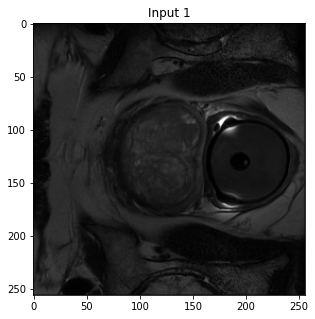

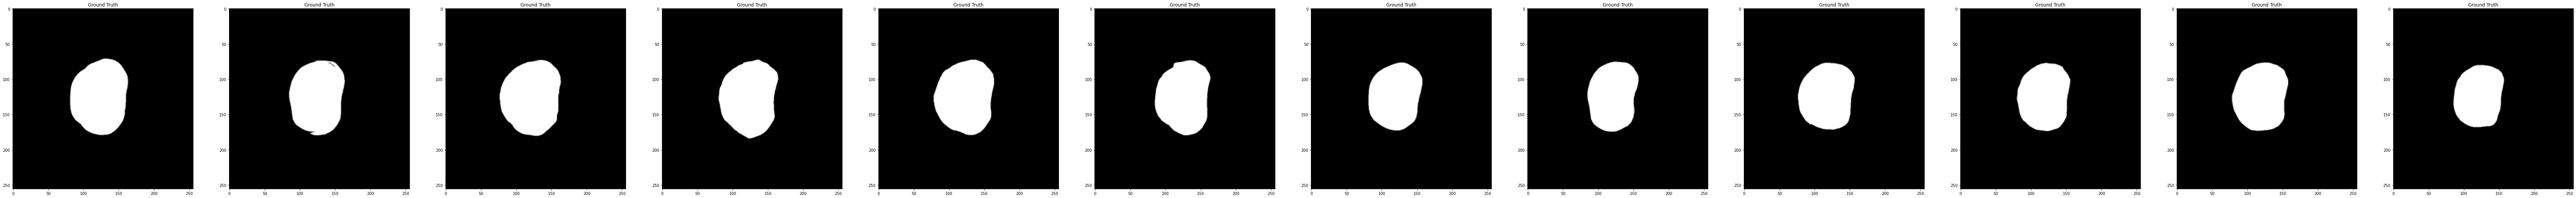

In [27]:
plt.figure(figsize=(5,5))
plt.imshow(X_train[0], cmap='gray')
plt.title('Input 1')
plt.show()

plt.figure(figsize=(10*NO_OF_MASKS,10))
for i in range(NO_OF_MASKS):
    plt.subplot(1,NO_OF_MASKS,i+1)
    plt.imshow(Y_train[i][0], cmap='gray')
    plt.title('Ground Truth')
plt.show()

In [28]:
X_train = np.array(X_train)
# ALL_IMG_FILES_INV = np.array(ALL_IMG_FILES_INV)
Y_train = np.array(Y_train)
print(X_train.shape)
# print(ALL_IMG_FILES_INV.shape)
print(Y_train.shape)

(55, 256, 256)
(12, 55, 256, 256)


In [30]:
X_test = np.array(X_test)
# ALL_IMG_FILES_INV = np.array(ALL_IMG_FILES_INV)
# Y_test = np.array(Y_test)
print(X_test.shape)
# print(ALL_IMG_FILES_INV.shape)
# print(Y_test.shape)

(13, 256, 256)


In [31]:
SUBMISSION_FILE_NAMES_ALL = sorted(glob.glob('/content/training_data_v3/prostate/Training/case05/*seg*'))
SUBMISSION_FILE_NAMES = []
for item in SUBMISSION_FILE_NAMES_ALL:
    SUBMISSION_FILE_NAMES.append(item.split('/')[-1])
SUBMISSION_FILE_NAMES

['task01_seg01.nii.gz',
 'task01_seg02.nii.gz',
 'task01_seg03.nii.gz',
 'task01_seg04.nii.gz',
 'task01_seg05.nii.gz',
 'task01_seg06.nii.gz',
 'task02_seg01.nii.gz',
 'task02_seg02.nii.gz',
 'task02_seg03.nii.gz',
 'task02_seg04.nii.gz',
 'task02_seg05.nii.gz',
 'task02_seg06.nii.gz']

In [32]:
# Remove the k fold and only use the training data 
# for training and the validation data for testing
Y_train_final = [[] for i in range(NO_OF_MASKS)]
# Y_test_final = [[] for i in range(NO_OF_MASKS)]

for iter_i in range(NO_OF_MASKS):
    Y_train_final[iter_i] = Y_train[iter_i].reshape((Y_train[iter_i].shape[0], Y_train[iter_i].shape[1], Y_train[iter_i].shape[2],1))
    # Y_test_final[iter_i] = Y_test[iter_i].reshape((Y_test[iter_i].shape[0], Y_test[iter_i].shape[1], Y_test[iter_i].shape[2],1))

for iter_i in range(NO_OF_MASKS):
    Y_train_final[iter_i] = np.round(Y_train_final[iter_i], 0)
    # Y_test_final[iter_i] = np.round(Y_test_final[iter_i], 0)


def saveModel(model):
    model_json = model.to_json()
    try:
        os.makedirs('models')
    except:
        pass
    fp = open('models/modelP_Qubiq.json','w')
    fp.write(model_json)
    model.save_weights('models/modelW_Qubiq.h5')


jaccard_index_list = []
dice_coeff_list = []

def evaluateModel(model, X_test, batchSize):
    try:
        os.makedirs('results')
    except:
        pass
    # testing part of the code
    yp = model.predict(x=X_test, batch_size=batchSize, verbose=1)
    yp = np.round(yp,0)
    print("Predicted yp shape = ",yp.shape)
    # jacard = 0
    # dice = 0
    # avg_precision = 0
    # count_dummy = 0
    print("No. of Samples to be predicted = ", len(X_test))
    for i in range(len(X_test)):
        # parsing through the files of test set
        # plt.figure(figsize=(NO_OF_MASKS*10,30))
        # plt.subplot(3,NO_OF_MASKS,1)
        # plt.imshow(X_test[i], cmap='gray')
        # plt.title('Input 1')
        

        for item in range(NO_OF_MASKS):
            # plt.subplot(3,NO_OF_MASKS,item+NO_OF_MASKS+1)
            # plt.imshow(Y_test[item][i].reshape(Y_test[item][i].shape[0],Y_test[item][i].shape[1]), cmap='gray')
            # plt.title('Ground Truth')

            # # for plotting the predicted ones
            # plt.subplot(3,NO_OF_MASKS,item+2*NO_OF_MASKS+1)
            # plt.imshow(yp[item][i].reshape(yp[item][i].shape[0],yp[item][i].shape[1]), cmap='gray')
            # plt.title('Prediction')

            save_name = "prostate/case{}/".format(CASE_NO+i+1) + str(SUBMISSION_FILE_NAMES[item])
            # save the file here in .nii.gz format
            save_file = yp[item][i].reshape(yp[item][i].shape[0],yp[item][i].shape[1])
            resized = cv2.resize(save_file,(640, 640), interpolation = cv2.INTER_AREA)
            nib.save(nib.Nifti1Image(resized, AFFINE), save_name)

            # yp_2 = yp[item][i].ravel()
            # y2 = Y_test[item][i].ravel()

            # intersection = yp_2 * y2
            # union = yp_2 + y2 - intersection
            # average_precision_score_got = average_precision_score(yp_2, y2)
            # jacard_got = (np.sum(intersection)/np.sum(union))
            # dice_got = (2. * np.sum(intersection) ) / (np.sum(yp_2) + np.sum(y2))
            # plt.suptitle('Jacard Index'+ str(np.sum(intersection)) +'/'+ str(np.sum(union)) +'='+str(jacard_got)
            #     +" Dice : "+str(dice_got)+ " Precision : "+str(average_precision_score_got))
            # avg_precision += average_precision_score_got
            # jacard += jacard_got
            # dice += dice_got
            # count_dummy+=1

    #     plt.savefig('results/'+str(i)+'.png',format='png')
    #     plt.close()
    
    # jacard /= count_dummy
    # dice /= count_dummy
    # avg_precision /= count_dummy


    # # recall_score /= len(Y_test)

    # print('Jacard Index : '+str(jacard))
    # print('Dice Coefficient : '+str(dice))
    # with open("Output.txt", "a") as text_file:
    #     text_file.write("Jacard : {} Dice Coef : {} Avg. Precision : {}  \n".format(
    #     str(jacard), str(dice), str(avg_precision)))
    
    # jaccard_index_list.append(jacard)
    # dice_coeff_list.append(dice)
    # fp = open('models/log_Qubiq.txt','a')
    # fp.write(str(jacard)+'\n')
    # fp.close()

    # fp = open('models/best_Qubiq.txt','r')
    # best = fp.read()
    # fp.close()

    # if(jacard>float(best)):
    #     print('***********************************************')
    #     print('Jacard Index improved from '+str(best)+' to '+str(jacard))
    #     print('***********************************************')
    #     fp = open('models/best_Qubiq.txt','w')
    #     fp.write(str(jacard))
    #     fp.close()

    #     saveModel(model)

In [37]:
def trainStep(model, X_train, Y_train, X_test, epochs, batchSize):

    history = model.fit(x=X_train, y=Y_train, batch_size=batchSize, epochs=epochs, verbose=1)

    # convert the history.history dict to a pandas DataFrame:
    hist_df = pd.DataFrame(history.history)

    # save to json:
    hist_json_file = 'history_Qubiq.json'
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv:
    hist_csv_file = 'history_Qubiq.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

    evaluateModel(model, X_test, batchSize)

    return model

# img_w, img_h, n_label, data_format='channels_first'
model = QUBIQ_NET(height=256, width=256, n_channels=1)

loss = {'out1': tversky_loss,
        'out2': tversky_loss,
        'out3': tversky_loss,
        'out4': tversky_loss,
        'out5': tversky_loss,
        'out6': tversky_loss,
        'out7': tversky_loss,
        'out8': tversky_loss,
        'out9': tversky_loss,
        'out10': tversky_loss,
        'out11': tversky_loss,
        'out12': tversky_loss
        }
    
loss_weights = {'out1':1,
                'out2':1,
                'out3':1,
                'out4':1,
                'out5':1,
                'out6':1,
                'out7':1,
                'out8':1,
                'out9':1,
                'out10':1,
                'out11':1,
                'out12':1
                }

model.compile(optimizer=Adam(learning_rate=1e-4),loss=loss, loss_weights=loss_weights,metrics=[dice_coef, jacard, Recall(), Precision(), 'accuracy'])

saveModel(model)

fp = open('models/log_Qubiq.txt','w')
fp.close()
fp = open('models/best_Qubiq.txt','w')
fp.write('-1.0')
fp.close()

trainStep(model, X_train, Y_train_final, X_test, epochs=100, batchSize=2)


Epoch 1/100
28/28 [==============================] - 81s 2s/step - loss: 9.5232 - out1_loss: 0.7457 - out2_loss: 0.7487 - out3_loss: 0.7258 - out4_loss: 0.7399 - out5_loss: 0.7391 - out6_loss: 0.7496 - out7_loss: 0.8256 - out8_loss: 0.8296 - out9_loss: 0.8190 - out10_loss: 0.8650 - out11_loss: 0.8496 - out12_loss: 0.8856 - out1_dice_coef: 0.1761 - out1_jacard: 0.0974 - out1_recall_1: 0.9461 - out1_precision_1: 0.0842 - out1_accuracy: 0.1199 - out2_dice_coef: 0.1735 - out2_jacard: 0.0957 - out2_recall_1: 0.9447 - out2_precision_1: 0.0825 - out2_accuracy: 0.1150 - out3_dice_coef: 0.1919 - out3_jacard: 0.1070 - out3_recall_1: 0.9326 - out3_precision_1: 0.0927 - out3_accuracy: 0.1352 - out4_dice_coef: 0.1805 - out4_jacard: 0.1000 - out4_recall_1: 0.9499 - out4_precision_1: 0.0874 - out4_accuracy: 0.1264 - out5_dice_coef: 0.1809 - out5_jacard: 0.1002 - out5_recall_1: 0.9589 - out5_precision_1: 0.0877 - out5_accuracy: 0.1200 - out6_dice_coef: 0.1714 - out6_jacard: 0.0945 - out6_recall_1: 0.9

Display file =  /content/prostate/case57/task01_seg02.nii.gz


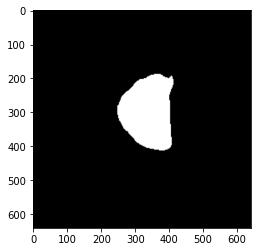

Display file =  /content/validation_data_qubiq2021/prostate/Validation/case57/image.nii.gz


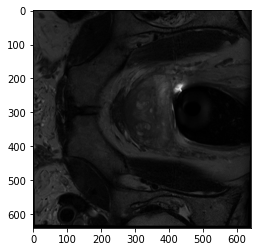

In [40]:
# check if this is what you exactly wanted
each_mask_file = glob.glob("/content/prostate/case57/*seg*")[0]
print("Display file = ",each_mask_file)
# print(each_mask_file)
epi_mask = nib.load(each_mask_file)
epi_mask_data = epi_mask.get_fdata()
plt.imshow(epi_mask_data,cmap='gray')
plt.show()

# check if this is what you exactly wanted
each_mask_file = glob.glob("/content/validation_data_qubiq2021/prostate/Validation/case57/*")[0]
print("Display file = ",each_mask_file)
# print(each_mask_file)
epi_mask = nib.load(each_mask_file)
epi_mask_data = epi_mask.get_fdata()
plt.imshow(np.squeeze(epi_mask_data),cmap='gray')
plt.show()

In [39]:
! zip -r prostate.zip prostate

  adding: prostate/ (stored 0%)
  adding: prostate/case62/ (stored 0%)
  adding: prostate/case62/task01_seg02.nii.gz (deflated 51%)
  adding: prostate/case62/task02_seg03.nii.gz (deflated 59%)
  adding: prostate/case62/task02_seg01.nii.gz (deflated 59%)
  adding: prostate/case62/task01_seg03.nii.gz (deflated 51%)
  adding: prostate/case62/task01_seg05.nii.gz (deflated 52%)
  adding: prostate/case62/task01_seg06.nii.gz (deflated 54%)
  adding: prostate/case62/task02_seg06.nii.gz (deflated 59%)
  adding: prostate/case62/task01_seg01.nii.gz (deflated 53%)
  adding: prostate/case62/task02_seg05.nii.gz (deflated 60%)
  adding: prostate/case62/task01_seg04.nii.gz (deflated 52%)
  adding: prostate/case62/task02_seg04.nii.gz (deflated 98%)
  adding: prostate/case62/task02_seg02.nii.gz (deflated 60%)
  adding: prostate/case59/ (stored 0%)
  adding: prostate/case59/task01_seg02.nii.gz (deflated 67%)
  adding: prostate/case59/task02_seg03.nii.gz (deflated 72%)
  adding: prostate/case59/task02_seg